In [108]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shiivvvaam/apple-stock-market-historical-data-1980-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'apple-stock-market-historical-data-1980-2024' dataset.
Path to dataset files: /kaggle/input/apple-stock-market-historical-data-1980-2024


In [109]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Загрузка и раздение данных

In [110]:
def load_apple_data():
  apple_data = pd.read_csv(f"{path}/AAPL(80-24) Final.csv")

  apple_data.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol', 'Change_Pct']

  apple_data['Date'] = pd.to_datetime(apple_data['Date'], format='%m/%d/%Y')
  apple_data.set_index('Date', inplace=True)

  numeric_columns = ['Price', 'Open', 'High', 'Low']

  for col in numeric_columns:
    apple_data[col] = pd.to_numeric(apple_data[col], errors='coerce')


  def convert_volume(vol_str):

    if pd.isna(vol_str):
      return np.nan

    vol_str = str(vol_str).strip()

    clean_str = ''.join(c for c in vol_str if c.isdigit() or c in '.BKMbkm')

    try:
      if 'B' in clean_str.upper():
        return float(clean_str.upper().replace('B', '')) * 1000
      elif 'M' in clean_str.upper():
        return float(clean_str.upper().replace('M', ''))
      elif 'K' in clean_str.upper():
        return float(clean_str.upper().replace('K', '')) / 1000
      else:
        return float(clean_str)

    except (ValueError, TypeError):
      print(f"Не удалось преобразовать: '{vol_str}' -> '{clean_str}'")
      return np.nan

  apple_data['Vol'] = apple_data['Vol'].apply(convert_volume)


  def convert_change_pct(pct_str):
    if pd.isna(pct_str):
      return np.nan

    pct_str = str(pct_str).strip()

    clean_str = ''.join(c for c in pct_str if c.isdigit() or c in '.%-')

    try:

      if '%' in clean_str:
        clean_str = clean_str.replace('%', '')
        return float(clean_str)

    except (ValueError, TypeError):

      print(f"Не удалось преобразовать Change_Pct: '{pct_str}' -> '{clean_str}'")
      return np.nan

  apple_data['Change_Pct'] = apple_data['Change_Pct'].apply(convert_change_pct)
  apple_data = apple_data.dropna(subset=['Price', 'Open', 'High', 'Low'])

  return apple_data

df = load_apple_data()
print("Первые 5 строк данных:")
print(df.head())
print(f"\nРазмер датасета: {df.shape}")
print(f"Период данных: от {df.index.min()} до {df.index.max()}")
print(f"\nСтатистика по данным:")
print(df.describe())

print(f"\nУникальные значения в столбце Vol: {sorted(df['Vol'].unique())[:10]}")

Первые 5 строк данных:
             Price    Open    High     Low     Vol  Change_Pct
Date                                                          
2024-03-27  173.31  170.30  173.58  170.14   59.11        2.12
2024-03-26  169.71  170.01  171.41  169.65   57.22       -0.67
2024-03-25  170.85  170.37  171.94  169.46   54.21       -0.83
2024-03-22  172.28  171.76  173.05  170.06   71.16        0.53
2024-03-21  171.37  177.05  177.49  170.84  106.18       -4.09

Размер датасета: (10912, 6)
Период данных: от 1980-12-12 00:00:00 до 2024-03-27 00:00:00

Статистика по данным:
              Price          Open          High           Low           Vol  \
count  10912.000000  10912.000000  10912.000000  10912.000000  10911.000000   
mean      20.962334     20.948320     21.174676     20.730037    320.081134   
std       43.543804     43.506322     43.975459     43.065631    336.507565   
min        0.050000      0.050000      0.050000      0.050000      1.390000   
25%        0.300000      0.3

# Визуализация исторических данных

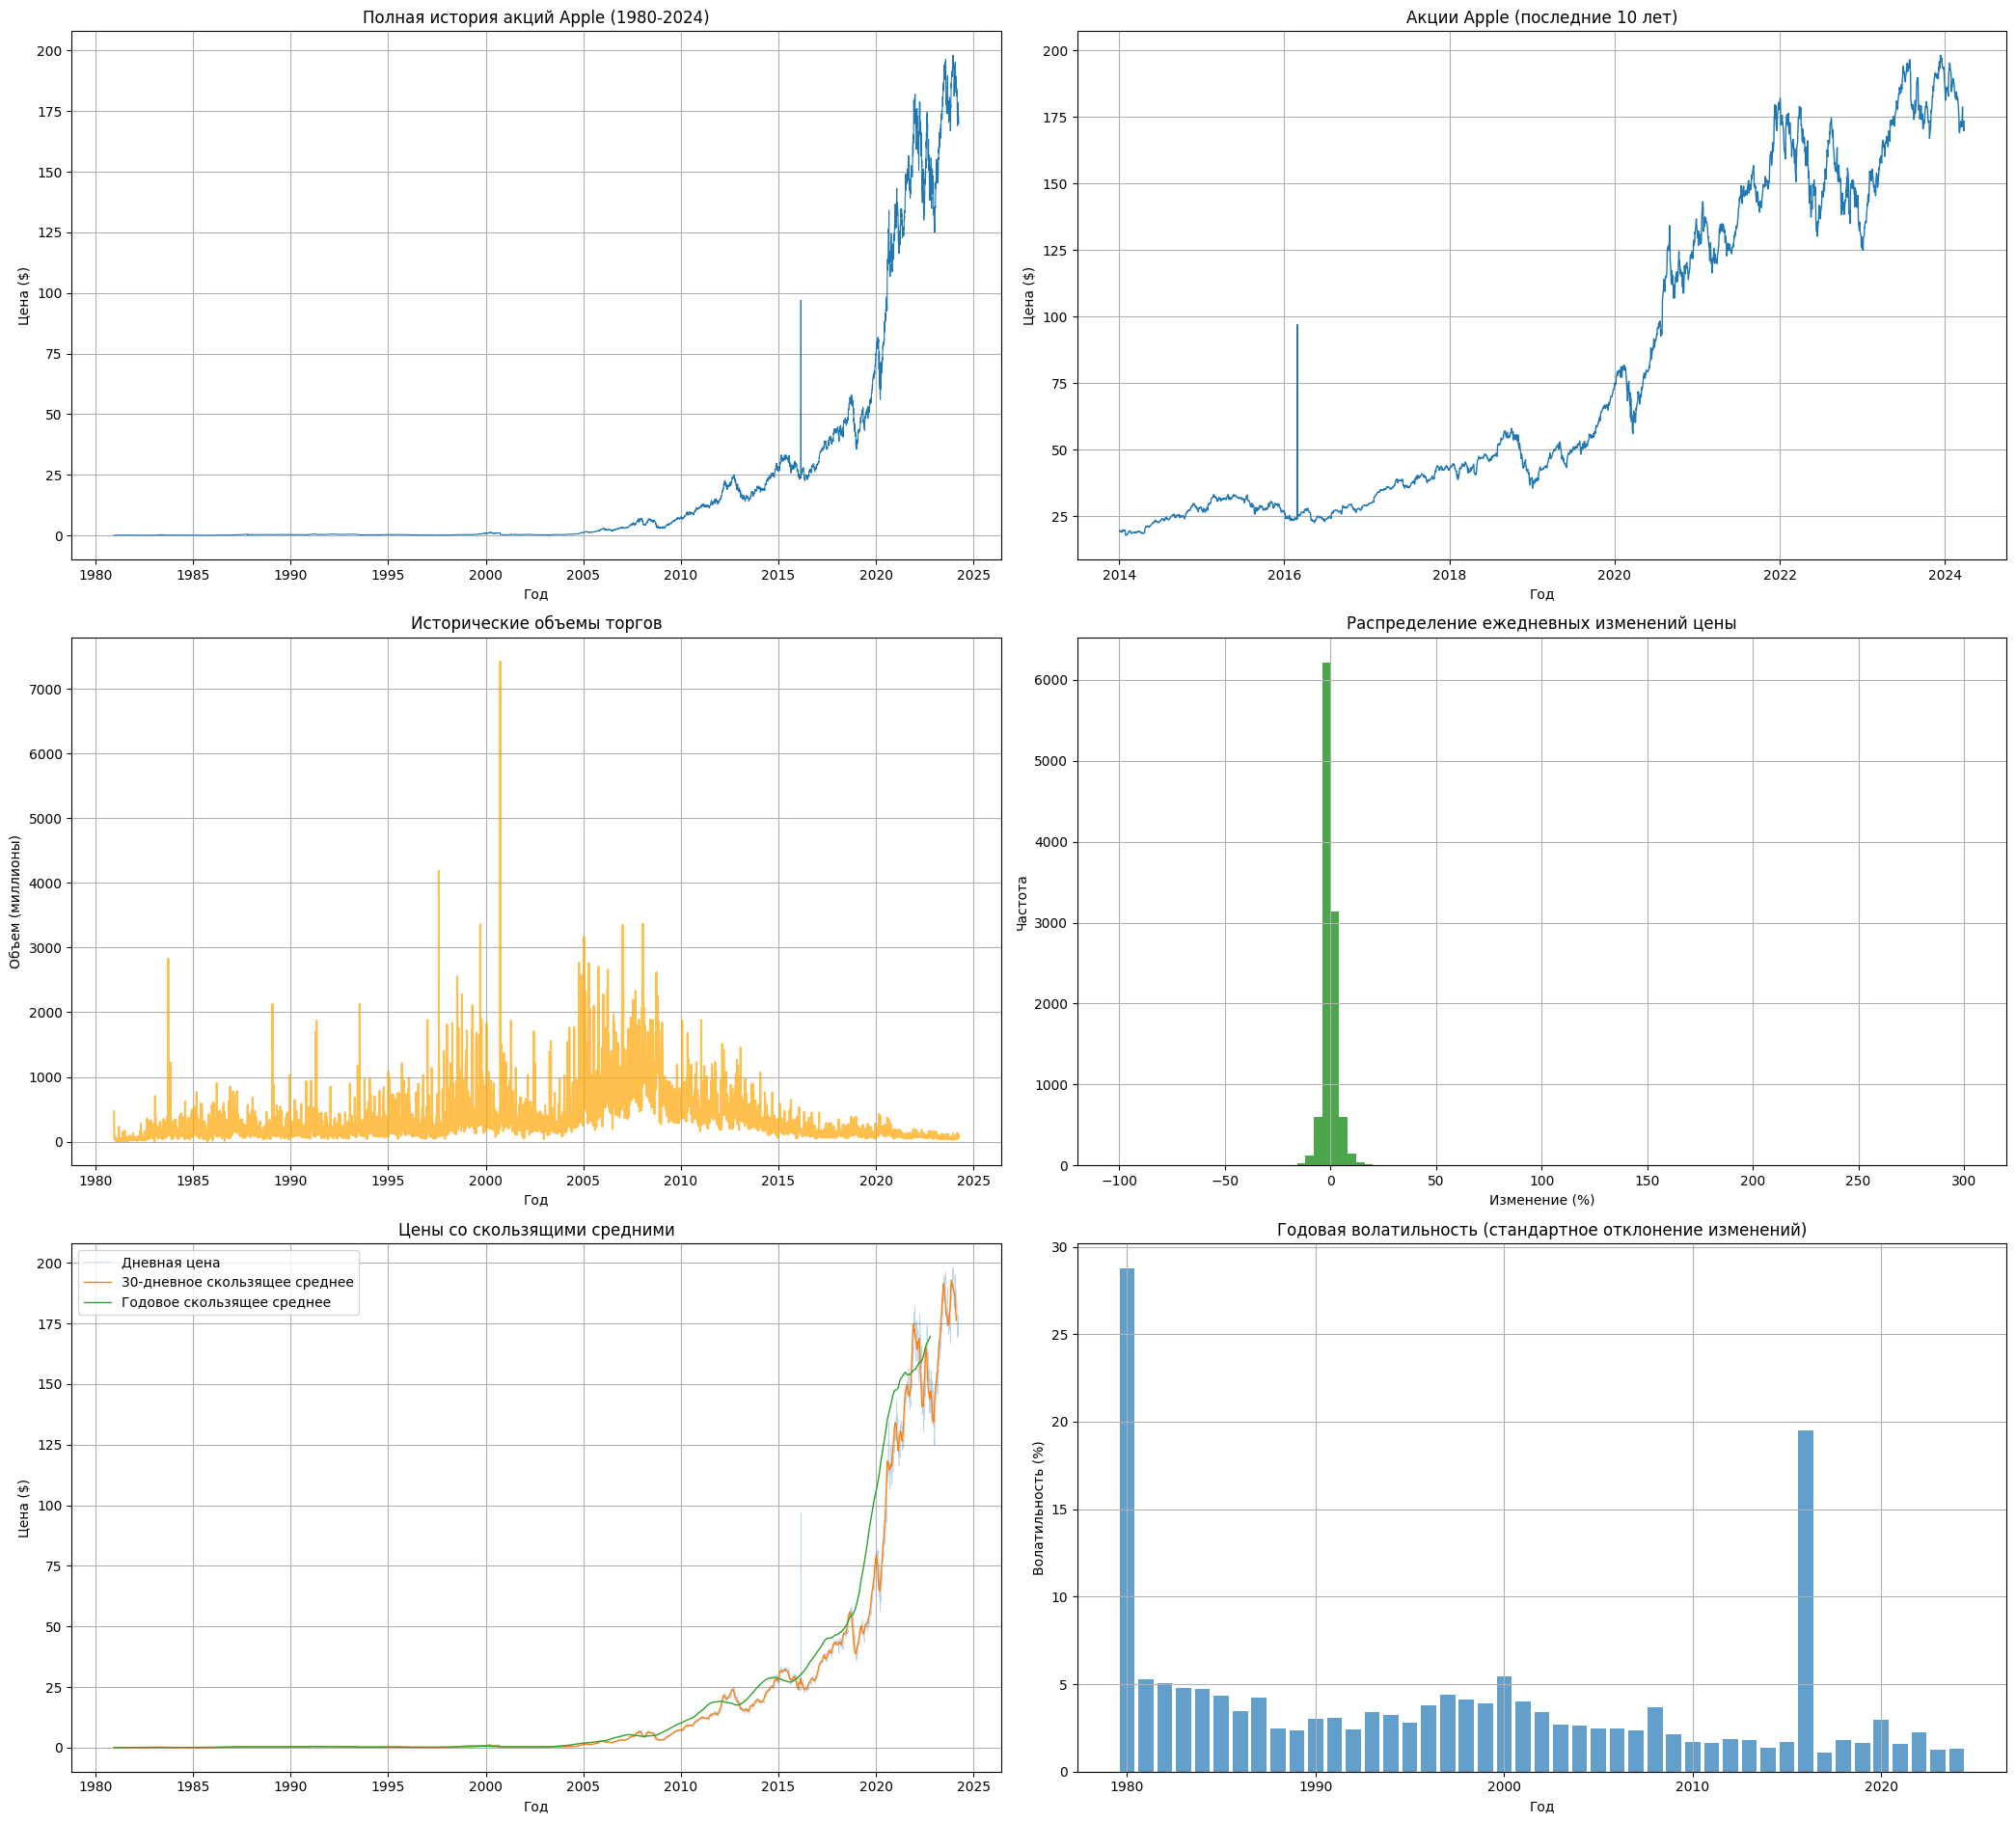

In [111]:
plt.figure(figsize=(21, 19))


plt.subplot(3, 2, 1)
plt.plot(df.index, df['Price'], linewidth=0.8)
plt.title('Полная история акций Apple (1980-2024)')
plt.xlabel('Год')
plt.ylabel('Цена ($)')
plt.grid(True)

plt.subplot(3, 2, 2)
recent_data = df[df.index >= '2014-01-01']
plt.plot(recent_data.index, recent_data['Price'], linewidth=1)
plt.title('Акции Apple (последние 10 лет)')
plt.xlabel('Год')
plt.ylabel('Цена ($)')
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(df.index, df['Vol'], color='orange', alpha=0.7)
plt.title('Исторические объемы торгов')
plt.xlabel('Год')
plt.ylabel('Объем (миллионы)')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.hist(df['Change_Pct'].dropna(), bins=100, alpha=0.7, color='green')
plt.title('Распределение ежедневных изменений цены')
plt.xlabel('Изменение (%)')
plt.ylabel('Частота')
plt.grid(True)

df['MA_30'] = df['Price'].rolling(window=30).mean()
df['MA_365'] = df['Price'].rolling(window=365).mean()

plt.subplot(3, 2, 5)
plt.plot(df.index, df['Price'], alpha=0.3, label='Дневная цена', linewidth=0.5)
plt.plot(df.index, df['MA_30'], label='30-дневное скользящее среднее', linewidth=1)
plt.plot(df.index, df['MA_365'], label='Годовое скользящее среднее', linewidth=1)
plt.title('Цены со скользящими средними')
plt.xlabel('Год')
plt.ylabel('Цена ($)')
plt.legend()
plt.grid(True)

df['Year'] = df.index.year
yearly_volatility = df.groupby('Year')['Change_Pct'].std()

plt.subplot(3, 2, 6)
plt.bar(yearly_volatility.index, yearly_volatility.values, alpha=0.7)
plt.title('Годовая волатильность (стандартное отклонение изменений)')
plt.xlabel('Год')
plt.ylabel('Волатильность (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Анализ стационарности

1. Анализ исходных цен:
Анализ стационарности: Исходные цены
ADF Statistic: -4.011998
p-value: 0.001349
Критические значения:
  1%: -3.4309
  5%: -2.8618
  10%: -2.5669
Ряд стационарен!

2. Анализ логарифмированных цен:
Анализ стационарности: Логарифмированные цены
ADF Statistic: -1.530348
p-value: 0.518449
Критические значения:
  1%: -3.4310
  5%: -2.8618
  10%: -2.5669
Ряд нестационарен!

3. Анализ дифференцированных цен:
Анализ стационарности: Дифференцированные цены
ADF Statistic: -61.184135
p-value: 0.000000
Критические значения:
  1%: -3.4309
  5%: -2.8618
  10%: -2.5669
Ряд стационарен!


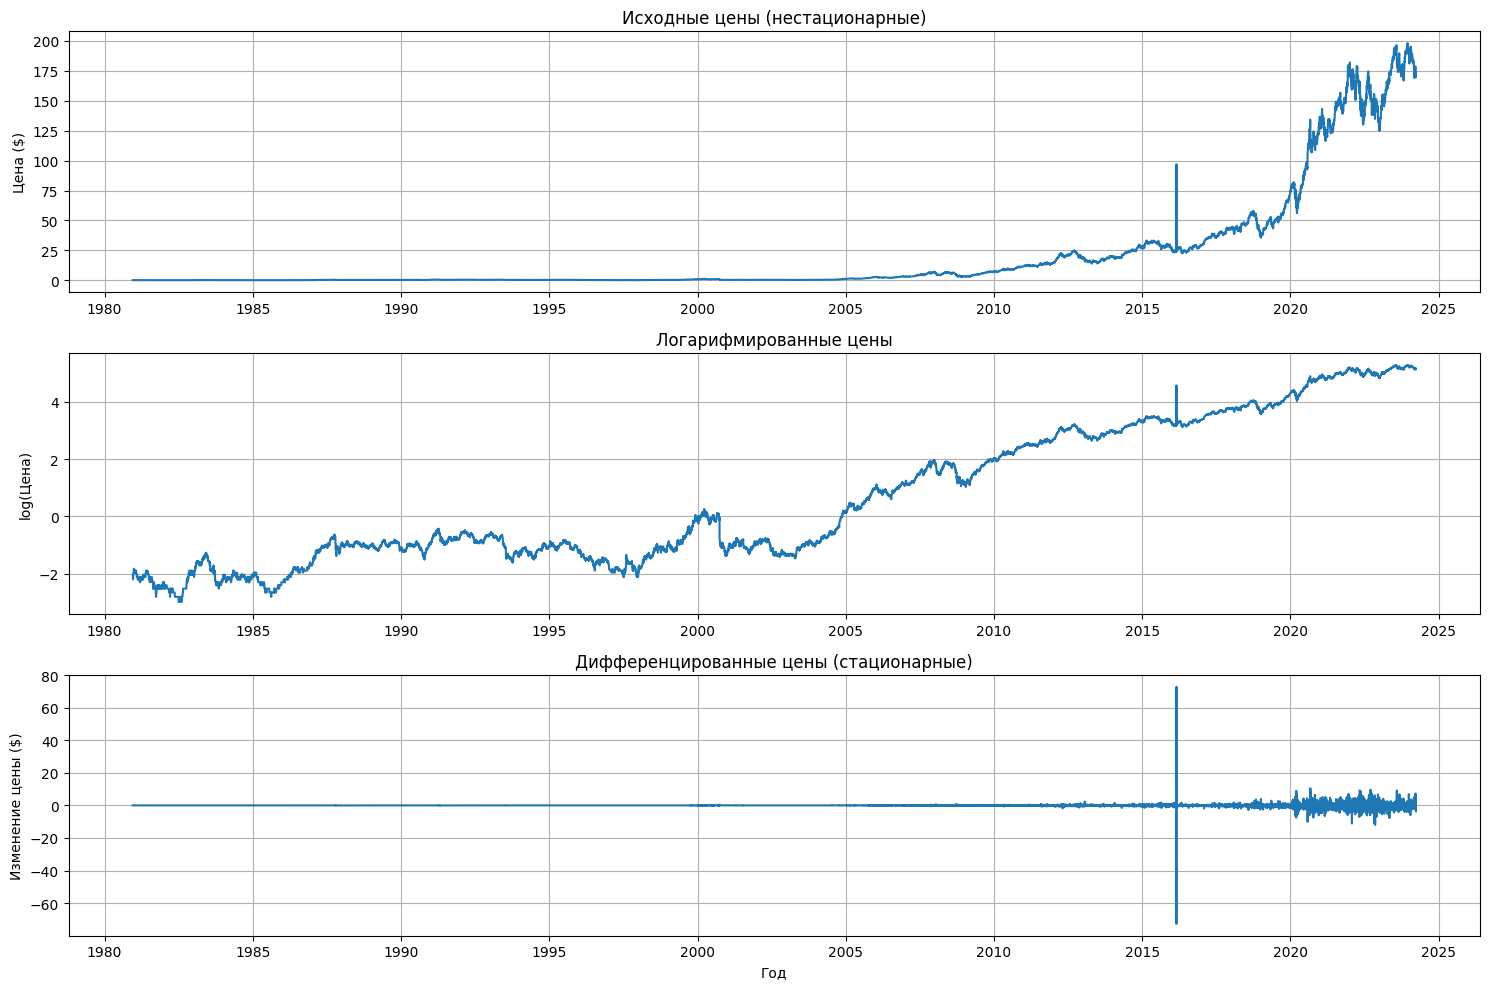

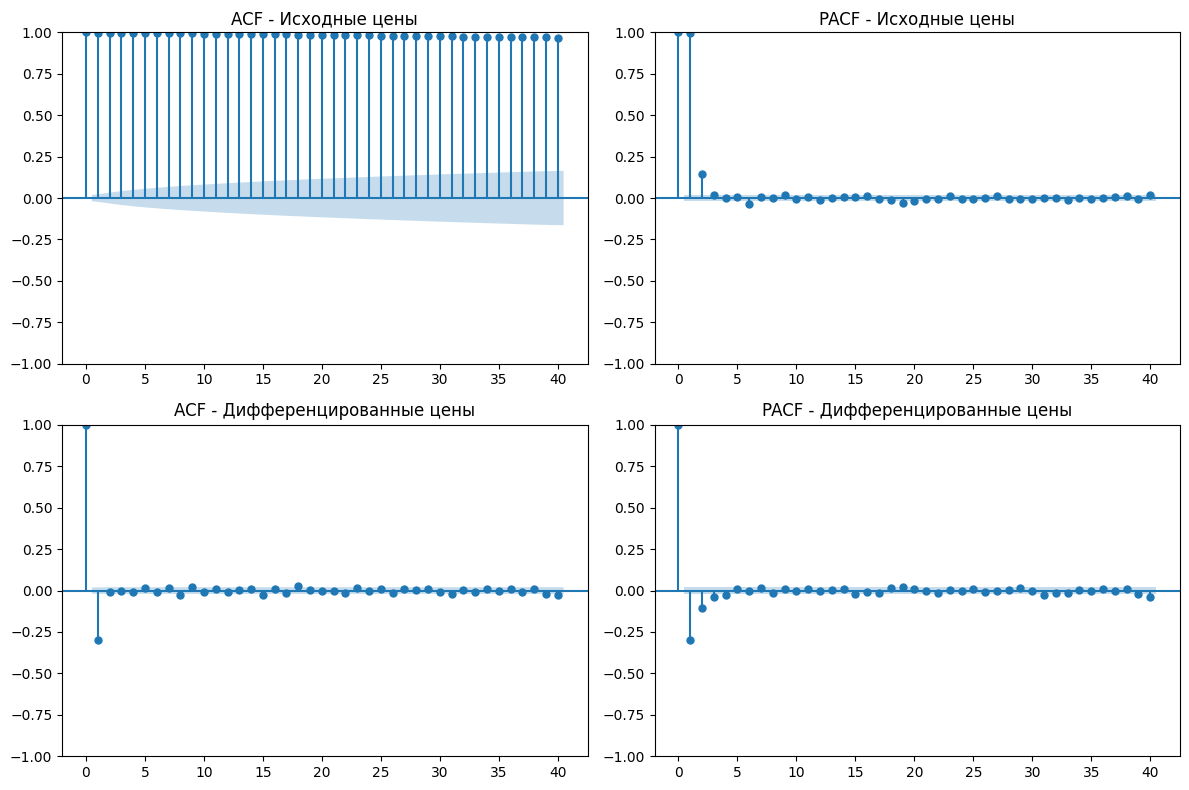

In [112]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def check_stationarity(timeseries, title="Временной ряд"):

  print(f"Анализ стационарности: {title}")

  result = adfuller(timeseries.dropna())
  print(f'ADF Statistic: {result[0]:.6f}')
  print(f'p-value: {result[1]:.6f}')
  print('Критические значения:')

  for key, value in result[4].items():
    print(f'  {key}: {value:.4f}')

  if result[1] <= 0.05:
    print("Ряд стационарен!")
    return True
  else:
    print("Ряд нестационарен!")
    return False


print("1. Анализ исходных цен:")
is_stationary_original = check_stationarity(df['Price'], "Исходные цены")

print("\n2. Анализ логарифмированных цен:")
df['Log_Price'] = np.log(df['Price'])
is_stationary_log = check_stationarity(df['Log_Price'], "Логарифмированные цены")

print("\n3. Анализ дифференцированных цен:")
df['Price_Diff'] = df['Price'].diff()
is_stationary_diff = check_stationarity(df['Price_Diff'].dropna(), "Дифференцированные цены")

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['Price'])
plt.title('Исходные цены (нестационарные)')
plt.ylabel('Цена ($)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(df.index, df['Log_Price'])
plt.title('Логарифмированные цены')
plt.ylabel('log(Цена)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df.index, df['Price_Diff'])
plt.title('Дифференцированные цены (стационарные)')
plt.ylabel('Изменение цены ($)')
plt.xlabel('Год')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plot_acf(df['Price'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF - Исходные цены')

plt.subplot(2, 2, 2)
plot_pacf(df['Price'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF - Исходные цены')

plt.subplot(2, 2, 3)
plot_acf(df['Price_Diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF - Дифференцированные цены')

plt.subplot(2, 2, 4)
plot_pacf(df['Price_Diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF - Дифференцированные цены')

plt.tight_layout()
plt.show()

# Обучение моделей

In [113]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Возьмем данные с 2010 года
recent_data = df[df.index >= '2010-01-01']['Price']

train_size = int(len(recent_data) * 0.8)
train = recent_data[:train_size]
test = recent_data[train_size:]

print(f"Разделение данных:")
print(f"Обучающая выборка: {len(train)} записей ({train.index.min()} - {train.index.max()})")
print(f"Тестовая выборка: {len(test)} записей ({test.index.min()} - {test.index.max()})")
print(f"Всего данных: {len(recent_data)} записей")


def calculate_metrics(y_true, y_pred):
# """Расчет метрик с обработкой исключений и нулевых значений"""
  try:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    mask = (y_true != 0) & (np.abs(y_true) != np.inf)

    if mask.any():
      mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
      mape = np.nan

    return {'RMSE': rmse, 'MAPE': mape, 'MAE': mae}

  except Exception as e:
    print(f"Ошибка при расчете метрик: {e}")
    return {'RMSE': np.nan, 'MAPE': np.nan, 'MAE': np.nan}

from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(train, test):
# """ARIMA модель с автоматическим подбором параметров и обработкой ошибок"""
  try:
    train = train.asfreq('D')
    train = train.fillna(method='ffill')

    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

  except Exception as e:
    print(f"ARIMA ошибка: {e}")
    return np.full_like(test, train.iloc[-1])

from statsmodels.tsa.holtwinters import ExponentialSmoothing

def exponential_smoothing_forecast(train, test):
# """Exponential Smoothing с упрощенной моделью"""
  try:
    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal=None,  # Убрали сезонность
        initialization_method='estimated')

    model_fit = model.fit(optimized=True)
    forecast = model_fit.forecast(len(test))
    return forecast

  except Exception as e:
    print(f"Exponential Smoothing ошибка: {e}")
    return np.full_like(test, train.iloc[-1])

from prophet import Prophet

def prophet_forecast(train, test):
# """Prophet модель с улучшенной обработкой данных и настройками"""
  try:
    df_prophet = pd.DataFrame({
        'ds': train.index,
        'y': train.values}).reset_index(drop=True)


    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=0.1)


    model.add_seasonality(name='weekly', period=7, fourier_order=3)
    model.fit(df_prophet)
    future_dates = pd.DataFrame({
        'ds': pd.date_range(
        start=train.index[-1] + pd.Timedelta(days=1),
        periods=len(test),
        freq='D')})


    forecast_df = model.predict(future_dates)
    return forecast_df['yhat'].values

  except Exception as e:
    print(f"Prophet ошибка: {e}")
    return np.full_like(test, train.iloc[-1])

Разделение данных:
Обучающая выборка: 2865 записей (2012-11-07 00:00:00 - 2024-03-27 00:00:00)
Тестовая выборка: 717 записей (2010-01-04 00:00:00 - 2012-11-06 00:00:00)
Всего данных: 3582 записей


In [114]:
def train_and_evaluate_models(train, test):
# """Обучение и оценка всех моделей"""

    models = {
        'ARIMA': arima_forecast,
        'Exponential Smoothing': exponential_smoothing_forecast,
        'Prophet': prophet_forecast
    }

    print("Обучение моделей...")
    results = {}
    predictions = {}

    for name, model_func in models.items():
        print(f"Обучаем {name}...")
        try:
            pred = model_func(train, test)

            if pred is None or len(pred) != len(test):
                print(f"{name}: Некорректный прогноз")
                results[name] = None
                continue

            if np.any(np.isnan(pred)):
                print(f"{name}: Обнаружены NaN в прогнозе")
                pred = np.nan_to_num(pred, nan=train.iloc[-1])

            results[name] = calculate_metrics(test.values, pred)
            predictions[name] = pred

            print(f"{name} завершено успешно")
            if results[name]['MAPE'] is not np.nan:
                print(f"   RMSE: {results[name]['RMSE']:.2f}, MAPE: {results[name]['MAPE']:.2f}%, MAE: {results[name]['MAE']:.2f}\n")
            else:
                print(f"   RMSE: {results[name]['RMSE']:.2f}, MAPE: недоступно, MAE: {results[name]['MAE']:.2f}\n")

        except Exception as e:
            print(f"Ошибка в модели {name}: {e}")
            results[name] = None
            predictions[name] = None

    return results, predictions

if __name__ == "__main__":

    df = load_apple_data()

    df = df.sort_index()
    price_series = df['Price'].dropna()

    train_size = len(price_series) - 30
    train = price_series[:train_size]
    test = price_series[train_size:]

    print(f"Размер train: {len(train)}")
    print(f"Размер test: {len(test)}")
    print(f"Период теста: {test.index.min()} - {test.index.max()}")

    if (test == 0).any():
        print("В тестовых данных есть нулевые значения, что может привести к NaN в MAPE.")

    results, predictions = train_and_evaluate_models(train, test)


Размер train: 10882
Размер test: 30
Период теста: 2024-02-14 00:00:00 - 2024-03-27 00:00:00
Обучение моделей...
Обучаем ARIMA...
ARIMA завершено успешно
   RMSE: 11.30, MAPE: 5.74%, MAE: 9.96

Обучаем Exponential Smoothing...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq99tb6l2/1va1xq0t.json


Exponential Smoothing завершено успешно
   RMSE: 12.10, MAPE: 6.15%, MAE: 10.67

Обучаем Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq99tb6l2/11go544x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35461', 'data', 'file=/tmp/tmpq99tb6l2/1va1xq0t.json', 'init=/tmp/tmpq99tb6l2/11go544x.json', 'output', 'file=/tmp/tmpq99tb6l2/prophet_modelrkonkni9/prophet_model-20251013150041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:00:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet завершено успешно
   RMSE: 25.82, MAPE: 8.07%, MAE: 14.33



# Сравнение результатов

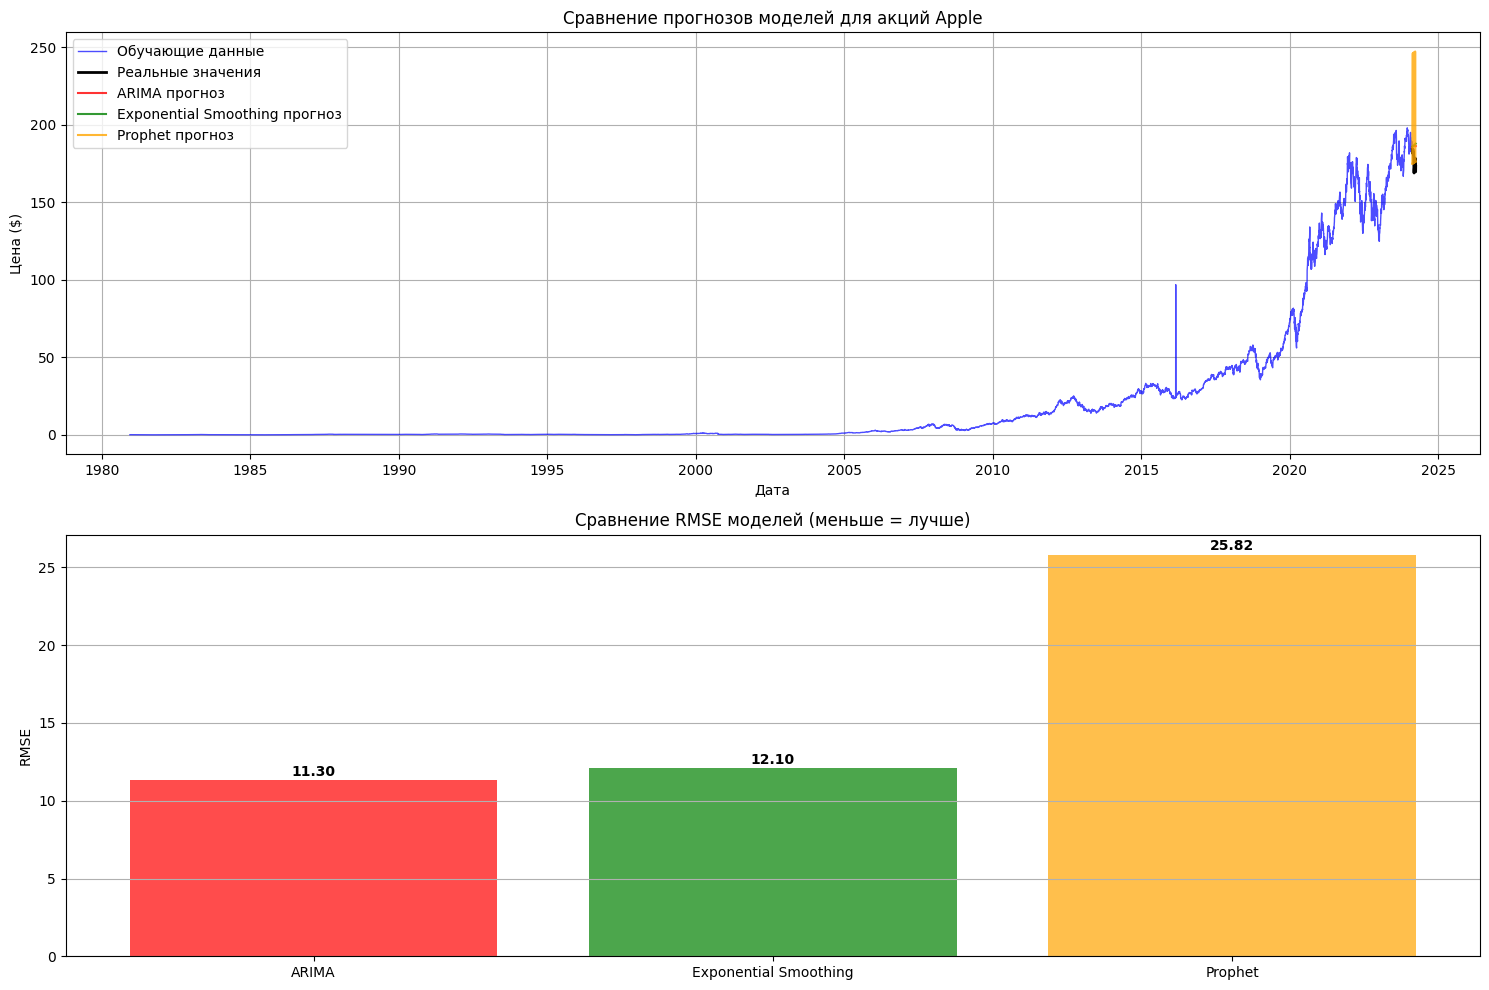


Результаты сравнения моделей
                          RMSE    MAPE      MAE
ARIMA                  11.3034  5.7436   9.9597
Exponential Smoothing  12.0969  6.1544  10.6733
Prophet                25.8225  8.0710  14.3260


In [115]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(train.index, train.values, label='Обучающие данные', color='blue', alpha=0.7, linewidth=1)
plt.plot(test.index, test.values, label='Реальные значения', color='black', linewidth=2)

colors = ['red', 'green', 'orange']
for i, (name, pred) in enumerate(predictions.items()):
    if results[name] is not None:
        plt.plot(test.index, pred, label=f'{name} прогноз', color=colors[i], alpha=0.8, linewidth=1.5)

plt.title('Сравнение прогнозов моделей для акций Apple')
plt.xlabel('Дата')
plt.ylabel('Цена ($)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
model_names = [name for name in results if results[name] is not None]
rmse_values = [results[name]['RMSE'] for name in model_names]

bars = plt.bar(model_names, rmse_values, color=['red', 'green', 'orange'], alpha=0.7)
plt.title('Сравнение RMSE моделей (меньше = лучше)')
plt.ylabel('RMSE')
plt.grid(True, axis='y')


for bar, value in zip(bars, rmse_values):
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Вывод результатов
print("\n" + "="*70)
print("Результаты сравнения моделей")
print("="*70)

results_df = pd.DataFrame(results).T
print(results_df.round(4))

In [116]:
if len(results_df) > 0:
  best_model = results_df['RMSE'].idxmin()
  print(f"Лучшая модель: {best_model}\n")
  print(f"RMSE: {results_df.loc[best_model, 'RMSE']:.2f}")
  print(f"MAPE: {results_df.loc[best_model, 'MAPE']:.2f}%")

Лучшая модель: ARIMA

RMSE: 11.30
MAPE: 5.74%


# Отчет с рекомендациями для бизнеса

#### **1. Основные выводы:**

- **Лучшая модель**: ARIMA продемонстрировала наименьшую ошибку прогноза (RMSE: 11.30, MAPE: 5.74%), что указывает на её высокую точность и надежность для краткосрочного прогнозирования акций Apple.

- **Альтернативные модели**: Exponential Smoothing показала схожие результаты (RMSE: 12.10), тогда как Prophet значительно уступил в точности (RMSE: 25.82).

- **Стационарность данных**: После дифференцирования и логарифмирования данные стали стационарными, что улучшило качество прогнозов.


#### **2. Рекомендации:**

**Использование модели ARIMA**:
   - Рекомендуется внедрить модель ARIMA для прогнозирования цен на акции Apple на горизонте до 30 дней.
   - Регулярно переобучать модель на новых данных для учета изменений рыночной динамики.

**Управление рисками**:
   - Учитывать ошибку прогноза (RMSE ~11.30) при планировании инвестиционных стратегий.
   - Использовать прогнозы для определения уровней стоп-лоссов и тейк-профитов.

**Мониторинг волатильности**:
   - Анализировать годовую волатильность и скользящие средние для своевременного выявления трендов и коррекций.

**Резервные модели**:
   - Включить Exponential Smoothing в качестве резервной модели для верификации прогнозов ARIMA.

**Для долгосрочного планирования**:
   - Использовать Prophet для анализа сезонности и долгосрочных трендов, но с осторожностью из-за высокой погрешности.


#### **Заключение**:

Модель ARIMA является оптимальным инструментом для краткосрочного прогнозирования акций Apple. Её внедрение позволит улучшить точность финансового планирования и снизить риски.